# HEART RATE ESTIMATION

Ballistocardiography(BCG) is an another technique to estimate heart and respiratory rate with combination of both accelerometer and gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., accelerometer platform mounted under the slats of the bed).

MuSe(Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provide by [221e](https://www.221e.com). In the context of this project, It allows to record the inertial data necessary for the estimation of SCG.

The dataset used (**4_Chest_sweater.txt**) provide measurments acquired from a sensor placed on a sweater laying on the patient chest. 

## Libraries:

The main libraries used to perform SCG are the following:

1. **Pandas**: to collect the dataset as DataFrame and select the columns of interest. 
* **Numpy**: to perform operations with arrays and use some usefull tools
* **Matplotlib**: to plot the resuls 
* **Seaborn**: to have a nice design of the plotted results 
* **Scipy**: to perform some numerical routines, such as linear algebra and statistics.

In [1]:
######  LIBRARIES  #######
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy import fft, ifft, stats
from scipy.signal import welch, butter, filtfilt, find_peaks
import pywt
import seaborn as sns
import matplotlib

## Data preparation:

In this first part the dataset is loaded as DataFrame. The columns of interest are selected to do a complete data analysis. A "Time" column is added. This one will be usefull in the last part of the project to understand at which time a heart beat occurs. 

The selected data are then plotted. These are the three components of both the Accelerometer and Gyroscope. Thanks to these plots we are able to have an opening view of how these signals look like. Moreover a very noisily area at the begin and at the end of those signals can be detected. As consequence the signals are then cutted to select just the central part. These part correspond to exactly 60 seconds of data collections. 

1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )

In [2]:
###### IMPORT DATA #######
file_name = "4_Chest_sweater.txt"

# creation of a DataFrame containing the whole dataset
df_chest = pd.DataFrame(pd.read_csv(file_name, sep = "\t", header = 0))

# select just the column of interest
df_chest = df_chest.iloc[:,[1,3,4,5,6,7,8]]

# recover the samples frequency
freq = df_chest['Log Freq'][0]

# create the time vector
time = np.arange(0, len(df_chest)* 1/freq, 1/freq)

# create the AccX, AccY, AccZ ,GyroX, GyroY, GyroZ vectors
accX, accY, accZ = df_chest['AccX'][:], df_chest['AccY'][:], df_chest['AccZ'][:]
gyroX,gyroY,gyroZ = df_chest['GyroX'][:], df_chest['GyroY'][:], df_chest['GyroZ'][:]

# insert time column
df_chest.insert(1, "Time", time)

# print data
df_chest.head()


,Log Freq,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
0,100,0.00,687.836,380.823,580.354,-7.926829,8.04878,0.975610
1,100,0.01,-812.703,-108.946,726.876,-11.707320,-81.82927,8.780488
2,100,0.02,-812.520,-108.824,733.952,-37.073170,-145.48780,14.756100
3,100,0.03,-787.144,-45.628,616.954,-56.341460,-174.63420,23.048780
4,100,0.04,-800.259,-137.433,411.689,-1.097561,37.07317,1.341463


2. Plot selected data in function of time and choose a properly time window over which to perform the analysis. Pay attention on time rappresentation and the measurament unit.

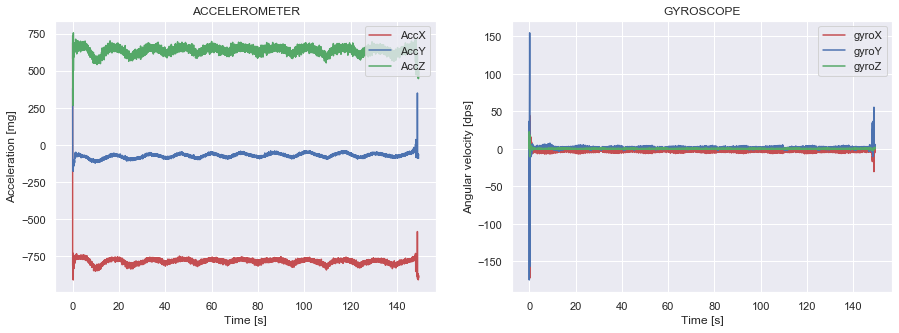

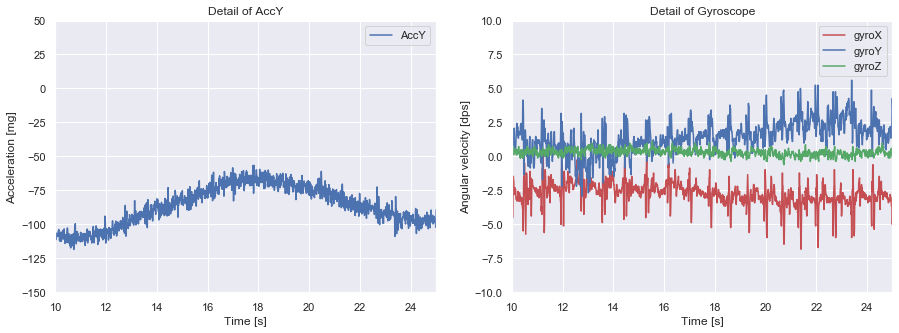

In [3]:
##### PLOT OF THE DATA #####
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sns.set()

# create the subplots 
figure, axis = plt.subplots(1,2, figsize = (15,5))

# plot the accelerometer's data
axis[0].plot(time,accX,'r',label = 'AccX')
axis[0].plot(time,accY,'b',label = 'AccY')
axis[0].plot(time,accZ,'g',label = 'AccZ')
axis[0].set_xlabel('Time [s]')
axis[0].set_ylabel('Acceleration [mg]')
axis[0].set_title('ACCELEROMETER')
axis[0].legend(loc = 1)

#plot the gyroscope's data
axis[1].plot(time,gyroX,'r',label = 'gyroX')
axis[1].plot(time,gyroY,'b',label = 'gyroY')
axis[1].plot(time,gyroZ,'g',label = 'gyroZ')
axis[1].set_xlabel('Time [s]')
axis[1].set_ylabel('Angular velocity [dps]')
axis[1].set_title('GYROSCOPE')
axis[1].legend(loc = 1)
#plt.savefig("Images/BCG/data.png")

# create the subplots for a detail of the previous ones
figure, axis = plt.subplots(1,2, figsize = (15,5))

# plot a detail of the accelerometer plot
axis[0].plot(time,accY,'b',label = 'AccY')
axis[0].set_xlabel('Time [s]')
axis[0].set_ylabel('Acceleration [mg]')
axis[0].set_title('Detail of AccY')
axis[0].set_ylim([-150,50])
axis[0].set_xlim([10,25])
axis[0].legend(loc = 1)

# plot a detail of the gyroscope plot
axis[1].plot(time,gyroX,'r',label = 'gyroX')
axis[1].plot(time,gyroY,'b',label = 'gyroY')
axis[1].plot(time,gyroZ,'g',label = 'gyroZ')
axis[1].set_xlabel('Time [s]')
axis[1].set_ylabel('Angular velocity [dps]')
axis[1].set_title('Detail of Gyroscope')
axis[1].set_ylim([-10,10])
axis[1].set_xlim([10,25])
axis[1].legend(loc = 1)
#plt.savefig("Images/BCG/data2.png")

plt.show()

In [4]:
# select interval of interest to avoid the large amount of noise at the beginning and at the end of the original
# signal
df_chest = df_chest[(df_chest['Time'] >= 5) & (df_chest['Time'] < 65)]

# update accX, accY, accZ, gyroX, gyroY, gyroZ according to the new interval of interest
time = np.arange(0, len(df_chest)* 1/freq, 1/freq)
accX, accY, accZ = df_chest['AccX'][:], df_chest['AccY'][:], df_chest['AccZ'][:]
gyroX, gyroY, gyroZ = df_chest['GyroX'][:], df_chest['GyroY'][:], df_chest['GyroZ'][:]


3. In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.

**PCA** (Principal Component Analysis) is a dimensionality reduction technique. It's used to extract relevant information in a big confusing dataset. The goal of PCA is to find a new basis to re-express a dataset in order to reveal interesting stucture.

The central idea of PCA is to find out redudancy between variables and remove it as much as possibile. The main steps of PCA are the following: 
1. Compute the data mean vector from the data matrix X. 
* Subtract off mean vector from the dataset.
* Calculate the sample covariance matrix Cx.
* Calculate eigenvectors of matrix Cx in order to obtain the matrix P (new base).
* Apply the change of base PX = Y. Y will be the tranformed data matrix, if digonal, is uncurrelated and so we won't have any redundacy.


**PCA for Accelerometer**

In this section the PCA is used over the three components of the Accelerometer. 

As consequence of the results, a new base is apply to the data matrix and we reduce it from three to two dimensions. This operation allow us to keep and amount of 94% of information from the original matrix.

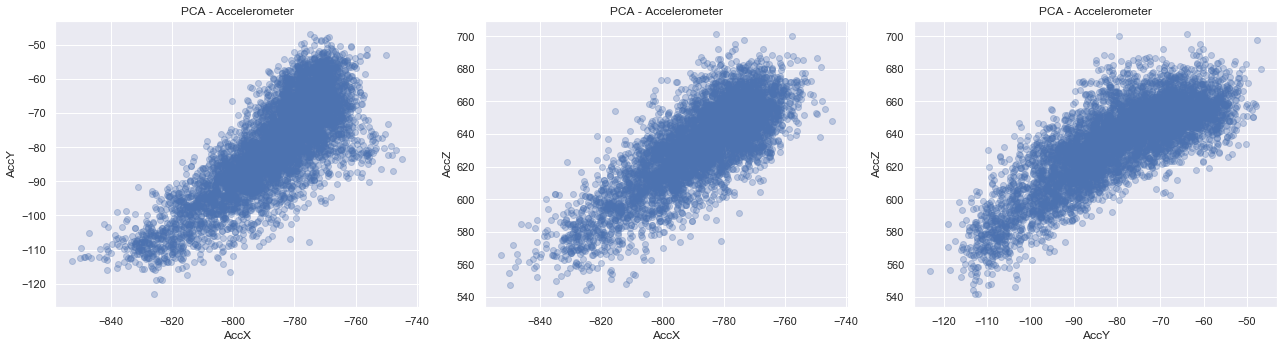

In [5]:
# create the matrix for the PCA technique, in the rows there are the AccX, AccY, AccZ measurments, and each 
# column represents a data sample
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sns.set()
X_acc = np.array([accX, accY, accZ])

figure, axis = plt.subplots(1,3, figsize = (18,5))
axis[0].scatter(X_acc[0,:], X_acc[1,:], alpha=0.3, color = 'b')
axis[0].set_xlabel('AccX')
axis[0].set_ylabel('AccY')
axis[0].set_title('PCA - Accelerometer')
axis[1].scatter(X_acc[0,:], X_acc[2,:], alpha=0.3, color = 'b')
axis[1].set_xlabel('AccX')
axis[1].set_ylabel('AccZ')
axis[1].set_title('PCA - Accelerometer')
axis[2].scatter(X_acc[1,:], X_acc[2,:], alpha=0.3, color = 'b')
axis[2].set_xlabel('AccY')
axis[2].set_ylabel('AccZ')
axis[2].set_title('PCA - Accelerometer')
figure.tight_layout()
#plt.savefig("Images/BCG/PCA_acc.png")
plt.show()

[[999.54   0.     0.  ]
 [  0.    84.85   0.  ]
 [  0.     0.    46.71]] 

Trace of the original data matrix:  1131.1
Trace of the data matrix after the changes of base:  1131.1 

Fraction of the total variability keeping only the first principal component:  88.0 %
Fraction of the total variability keeping only the first two principal components:  96.0 %
Fraction of the total variability keeping only the last two principal components:  12.0 %


C:\Users\Tony\miniconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Tony\miniconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


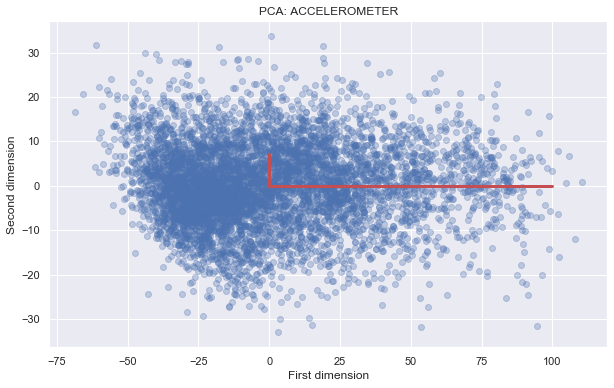

In [6]:
# compute the mean of X and subtract it to obtain a zero main matrix X
avg = X_acc.mean()
X_acc = X_acc - avg

# calculate the eigenvalues and eigenvectors of the covariance matrix and compute the covarinace matrix of the new 
# matrix 
l, V = la.eig(np.cov(X_acc))
Cy = np.diag(np.round(np.real(l),2))
print(Cy, "\n")


# estimate if reduce dimensionality is convenient 
print("Trace of the original data matrix: " , np.round(np.cov(X_acc).trace(),2))
print("Trace of the data matrix after the changes of base: ", np.round(Cy.trace(),2), "\n")

print("Fraction of the total variability keeping only the first principal component: ", np.round(100*(Cy[0,0])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the first two principal components: ", np.round(100*(Cy[0,0]+Cy[1,1])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the last two principal components: ", np.round(100*(Cy[1,1]+Cy[2,2])/Cy.trace()),"%")

# as consequence of the PCA technique keeping the two principal components for the Accelerometer is better

P = V[:,0:2] #the eigenvectors are in the columns of V

PCA_acc = P.T.dot(X_acc) # new data according to PCA result

#Visualize the original data projected into the new space with the relative principal axis
scale_factor = 0.001
first_dim = PCA_acc[0] - PCA_acc[0].mean()
second_dim = PCA_acc[1] - PCA_acc[1].mean()
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sns.set()
plt.figure(figsize=(10,6))
plt.scatter(first_dim, second_dim, alpha=0.3, c = 'b')
plt.plot([0, 0.1*scale_factor*l[0]*np.cov(PCA_acc)[0,0]], [0, scale_factor*l[0]*np.cov(PCA_acc)[1,0]], 'r', lw=3)
plt.plot([0, 0.1*scale_factor*l[1]*np.cov(PCA_acc)[0,1]], [0, scale_factor*l[1]*np.cov(PCA_acc)[1,1]], 'r', lw=3)
plt.title('PCA: ACCELEROMETER')
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
#plt.savefig("Images/BCG/PCA_acc2.png")
plt.show()

**PCA for Gyroscope**

In this section the PCA is used over the three components of the Gyroscope. 

As consequence of the results, we don't apply a new base so we keep all the three dimensions. This allow us to not lose too much information. 

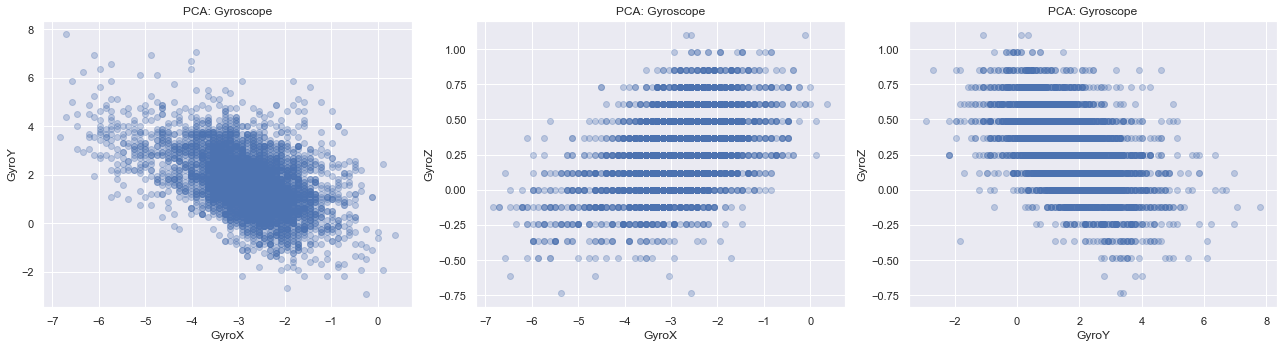

In [7]:
X_gyro = np.array([gyroX, gyroY, gyroZ]) 
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sns.set()
figure, axis = plt.subplots(1,3, figsize = (18,5))
axis[0].scatter(X_gyro[0,:], X_gyro[1,:], alpha=0.3, color = 'b')
axis[0].set_xlabel('GyroX')
axis[0].set_ylabel('GyroY')
axis[0].set_title('PCA: Gyroscope')
axis[1].scatter(X_gyro[0,:], X_gyro[2,:], alpha=0.3, color = 'b')
axis[1].set_xlabel('GyroX')
axis[1].set_ylabel('GyroZ')
axis[1].set_title('PCA: Gyroscope')
axis[2].scatter(X_gyro[1,:], X_gyro[2,:], alpha=0.3, color = 'b')
axis[2].set_xlabel('GyroY')
axis[2].set_ylabel('GyroZ')
axis[2].set_title('PCA: Gyroscope')
figure.tight_layout()
#plt.savefig("Images/BCG/PCA-gyro.png")
plt.show()

[[1.52 0.   0.  ]
 [0.   0.43 0.  ]
 [0.   0.   0.04]] 

Trace of the original data matrix:  1.99
Trace of the data matrix after the changes of base:  1.99 

Fraction of the total variability keeping only the first principal component:  76.0 %
Fraction of the total variability keeping only the first two principal components:  98.0 %
Fraction of the total variability keeping only the last two principal components:  24.0 %


C:\Users\Tony\miniconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Tony\miniconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


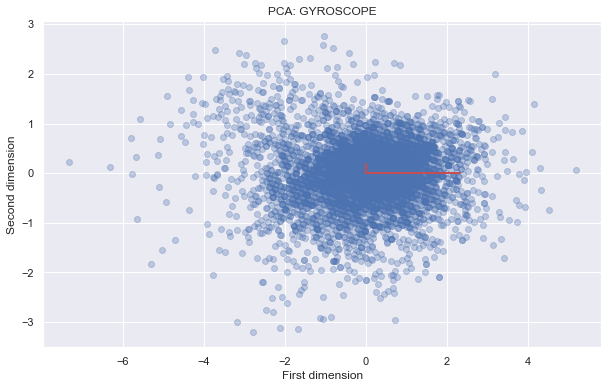

In [8]:
#compute the mean of X and subtract it to obtain a zero main matrix X
X_gyro = X_gyro - X_gyro.mean()

# calculate the eigenvalues and eigenvectors of the covariance matrix and compute the covarinace matrix of the new 
# matrix 
l, V = la.eig(np.cov(X_gyro))
Cy = np.diag(np.round(np.real(l),2))
print(Cy, "\n")


# estimate if reduce dimensionality is convenient 
print("Trace of the original data matrix: " , np.round(np.cov(X_gyro).trace(),2))
print("Trace of the data matrix after the changes of base: ", np.round(Cy.trace(),2), "\n")

print("Fraction of the total variability keeping only the first principal component: ", np.round(100*(Cy[0,0])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the first two principal components: ", np.round(100*(Cy[0,0]+Cy[1,1])/Cy.trace()),"%")
print("Fraction of the total variability keeping only the last two principal components: ", np.round(100*(Cy[1,1]+Cy[2,2])/Cy.trace()),"%")

# as consequence of the PCA technique keeping the two principal components for the Gyroscope is better
P = V[:,0:2] #the eigenvectors are in the columns of V

PCA_gyro = P.T.dot(X_gyro) # new data according to PCA result

#Visualize the original data projected into the new space with the relative principal axis
first_dim = PCA_gyro[0] - PCA_gyro[0].mean()
second_dim = PCA_gyro[1] - PCA_gyro[1].mean()
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sns.set()
plt.figure(figsize=(10,6))
plt.scatter(first_dim, second_dim, alpha=0.3, c = 'b')
plt.plot([0, l[0]*np.cov(PCA_gyro)[0,0]], [0, l[0]*np.cov(PCA_gyro)[1,0]], 'r', lw=2)
plt.plot([0, l[1]*np.cov(PCA_gyro)[0,1]], [0, l[1]*np.cov(PCA_gyro)[1,1]], 'r', lw=2)
plt.title('PCA: GYROSCOPE')
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
#plt.savefig("Images/BCG/PCA-gyro2.png")
plt.show()

## Time and frequency analysis:

1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.

In [9]:
# compute statistics
stat = df_chest.describe()
stat.round(1)
stat = stat.iloc[:,1:].round(1) 

# TODO: add correlation coeffs grassie
stat



,Time,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
count,6000.0,6000.0,6000.0,6000.0,6000.0,6000.0,6000.0
mean,35.0,-786.9,-79.7,634.4,-2.8,1.6,0.3
std,17.3,16.7,14.3,25.5,0.8,1.1,0.2
min,5.0,-852.7,-123.1,541.5,-6.8,-2.9,-0.7
25%,20.0,-796.9,-89.5,619.3,-3.2,0.9,0.1
50%,35.0,-783.6,-78.9,638.7,-2.8,1.5,0.2
75%,50.0,-774.5,-68.4,652.8,-2.3,2.2,0.5
max,65.0,-744.7,-46.8,701.6,0.4,7.8,1.1


    
2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step. 

C:\Users\Tony\miniconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  This is separate from the ipykernel package so we can avoid doing imports until


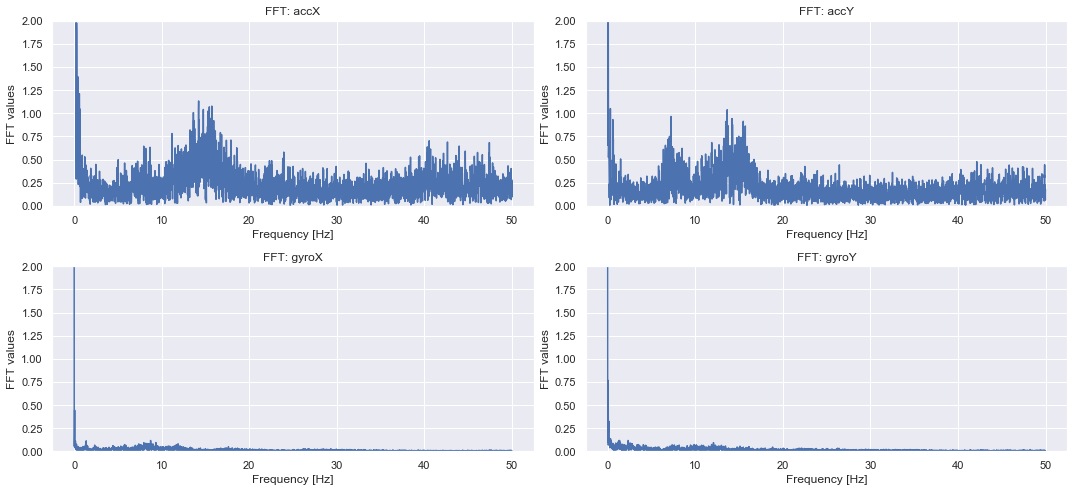

In [10]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)      
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])     
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

N = df_chest.shape[0]
T = 1/freq   
f_s = freq   

f_accX, fft_accX = get_fft_values(np.array(PCA_acc[0]), T, N, f_s)
f_accY, fft_accY  = get_fft_values(np.array(PCA_acc[1]), T, N, f_s)
f_gyroX, fft_gyroX = get_fft_values(np.array(X_gyro[0,:]), T, N, f_s)
f_gyroY, fft_gyroY = get_fft_values(np.array(X_gyro[1,:]), T, N, f_s)


figure, axis = plt.subplots(2, 2, figsize = (15, 7))
axis[0, 0].plot(f_accX, fft_accX)
axis[0, 0].set_ylim([0, 2])
axis[0, 0].set_xlabel('Frequency [Hz]')
axis[0, 0].set_ylabel('FFT values')
axis[0, 0].set_title('FFT: accX')
axis[0, 1].plot(f_accY, fft_accY)
axis[0, 1].set_ylim([0, 2])
axis[0, 1].set_xlabel('Frequency [Hz]')
axis[0, 1].set_ylabel('FFT values')
axis[0, 1].set_title('FFT: accY')
axis[1, 0].plot(f_gyroX, fft_gyroX)
axis[1, 0].set_ylim([0, 2])
axis[1, 0].set_xlabel('Frequency [Hz]')
axis[1, 0].set_ylabel('FFT values')
axis[1, 0].set_title('FFT: gyroX')
axis[1, 1].plot(f_gyroY, fft_gyroY)
axis[1, 1].set_ylim([0, 2])
axis[1, 1].set_xlabel('Frequency [Hz]')
axis[1, 1].set_ylabel('FFT values')
axis[1, 1].set_title('FFT: gyroY')
figure.tight_layout()
#plt.savefig("Images/BCG/FFT.png")
plt.show()




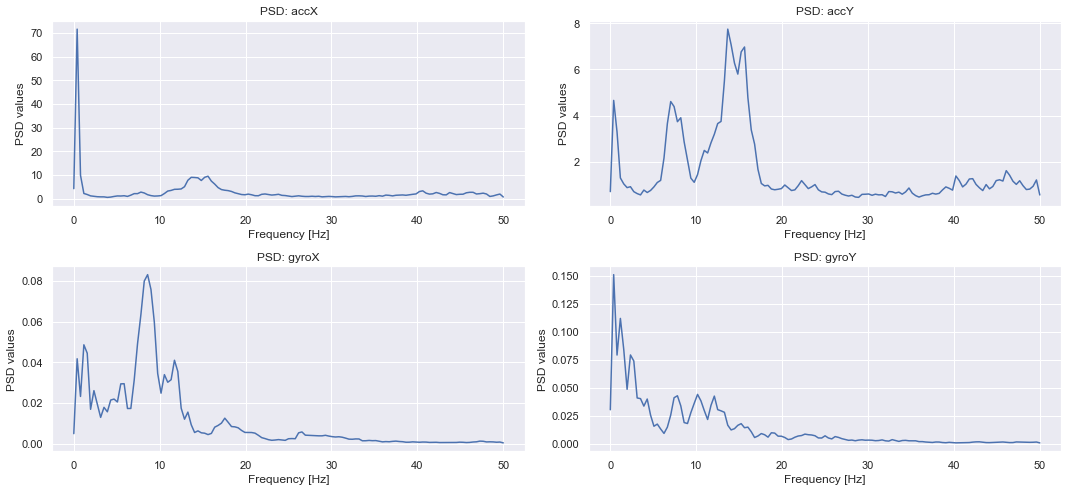

In [11]:
f_accX_psd, fft_accX_psd = get_psd_values(np.array(PCA_acc[0]), T, N, f_s)
f_accY_psd, fft_accY_psd  = get_psd_values(np.array(PCA_acc[1]), T, N, f_s)
f_gyroX_psd, fft_gyroX_psd = get_psd_values(np.array(X_gyro[0,:]), T, N, f_s)
f_gyroY_psd, fft_gyroY_psd = get_psd_values(np.array(X_gyro[1,:]), T, N, f_s)

figure, axis = plt.subplots(2, 2, figsize = (15, 7))
axis[0, 0].plot(f_accX_psd, fft_accX_psd)
axis[0, 0].set_xlabel('Frequency [Hz]')
axis[0, 0].set_ylabel('PSD values')
axis[0, 0].set_title('PSD: accX')
#axis[0, 0].set_ylim([0, 2])
axis[0, 1].plot(f_accY_psd, fft_accY_psd)
axis[0, 1].set_xlabel('Frequency [Hz]')
axis[0, 1].set_ylabel('PSD values')
axis[0, 1].set_title('PSD: accY')
#axis[0, 1].set_ylim([0, 2])
axis[1, 0].plot(f_gyroX_psd, fft_gyroX_psd)
axis[1, 0].set_xlabel('Frequency [Hz]')
axis[1, 0].set_ylabel('PSD values')
axis[1, 0].set_title('PSD: gyroX')
#axis[1, 0].set_ylim([0, 2])
axis[1, 1].plot(f_gyroY_psd, fft_gyroY_psd)
axis[1, 1].set_xlabel('Frequency [Hz]')
axis[1, 1].set_ylabel('PSD values')
axis[1, 1].set_title('PSD: gyroY')
#axis[1, 1].set_ylim([0, 2])
figure.tight_layout()
#plt.savefig("Images/BCG/PSD.png")
plt.show()

The PSD plots of the two gyro components show the power is evenly distributed in the whole spectrum, suggesting no useful signal can be recovered.

The acceleration components instead both have a heavy presence of noise in the 10-20 Hz band, however in the first acceleration component the peak in the low frequency may indicate the presence of the heartbeat signal, so we chose this one to be filtered.

**Filter:**
    
Now we try three different approaches for filtering the signal 
    
   (1) Directly in the frequency domain by zeroing the FT coefficient related to frequencies outside the band of interest           of [40,100] BPM, then antitrasforming
    
   (2) Butterworth Bandpass filter with the same BPM range
    
   (3) Multilevel Wavelet trasform  

In [12]:
def fftfilt(x,lf,hf,fs):
    X = np.fft.rfft(x)
    f = np.fft.rfftfreq(len(x),1/fs)
    X_filt = np.array([X[i] if (f[i] >= lf and f[i] <= hf) else 0 for i in range(0,len(X))]) # set to 0 the frequencies outside the BPM range
    x_filt = np.fft.irfft(X_filt)
    return x_filt

def butterfilt(x, lf, hf, fs):
    b,a = butter(4,[lf,hf], btype='bandpass', fs=fs)
    x_filt = filtfilt(b,a, x)  
    return x_filt 

def wave_dec(data, w,levels):

    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []
    for i in range(levels):
        a, d = pywt.dwt(a, w)
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))

    fig1 = plt.figure(figsize=(20,10))
    ax_main = fig1.add_subplot(len(rec_a) + 1, 1, 1)
    ax_main.set_title("WAVELET DECOMPOSITION - Original signal", fontsize = 16)
    data = np.array(data) 
    ax_main.plot(time,data)
    ax_main.set_xlim(35,40)
    ax_main.set_xlabel("Time [s]")
    #plt.savefig("Images/BCG/dec1.png")
    #ax_main.set_xlim(0, len(data) - 1)
    fig = plt.figure(figsize=(20,10))
    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) +1, 2, 3 + i * 2)
        ax.plot(time,y[:len(time)], 'r')
        #ax.set_xlim(0, len(y) - 1)
        ax.set_xlim(30,35)
        ax.set_title("Approx%d" % (i + 1))
        ax.set_xlabel("Time [s]")

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) +1, 2, 4 + i * 2)
        ax.plot(time,y[:len(time)], 'g')
        #ax.set_xlim(0, len(y) - 1)
        ax.set_xlim(30,35)
        ax.set_title("Detail%d" % (i + 1))
        ax.set_xlabel("Time [s]")
    fig.tight_layout()
    #plt.savefig("Images/BCG/dec2.png")
    return rec_a,rec_d,ca,cd


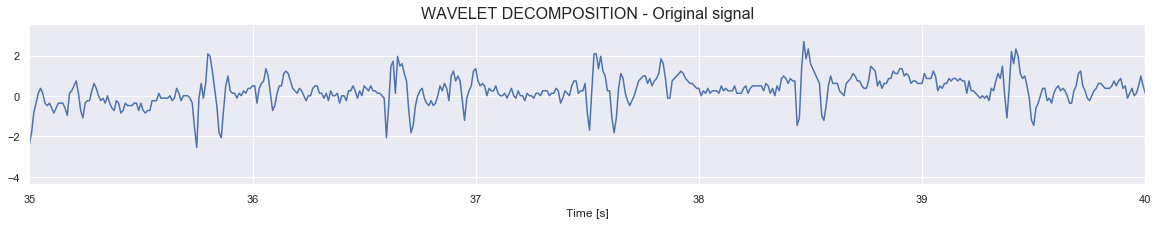

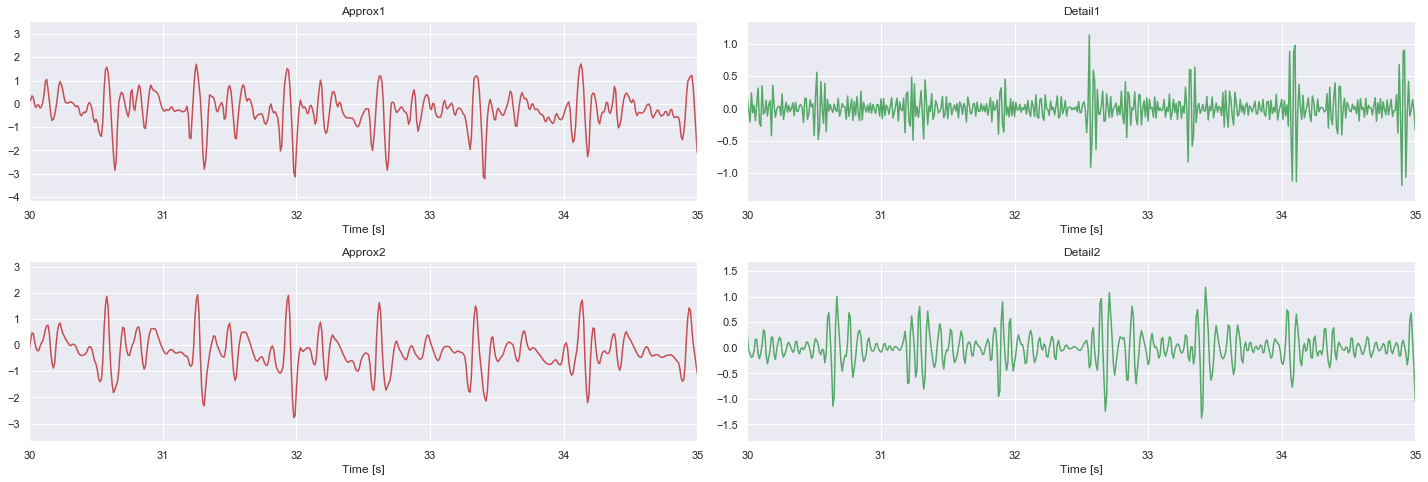

In [13]:
selected = (PCA_acc[0]-np.mean(PCA_acc[0]))
selected = gyroX-np.mean(gyroX)
fs = freq
lf = 40/60 #low band limit 40 bmp to Hz
hf = 100/60  #high band limit 100 bmp to Hz
wavelet = "sym5"
levels = 2

sig_filt_fft = fftfilt(selected,lf,hf,fs)
sig_filt_butter = butterfilt(selected,lf,hf,fs)
rec_a,rec_d,ca,cd = wave_dec(selected, wavelet,levels)

In [14]:
threshold = 0.5

coeffs = []
coeffs.append(pywt.threshold(ca[-1],np.sqrt(threshold*np.log(ca[-1].size))))
[coeffs.append(pywt.threshold(cdx,np.sqrt(threshold*np.log(cdx.size)))) for cdx in reversed(cd)]
wavelet_filt = pywt.waverec(coeffs, wavelet)

**Filtered signals**

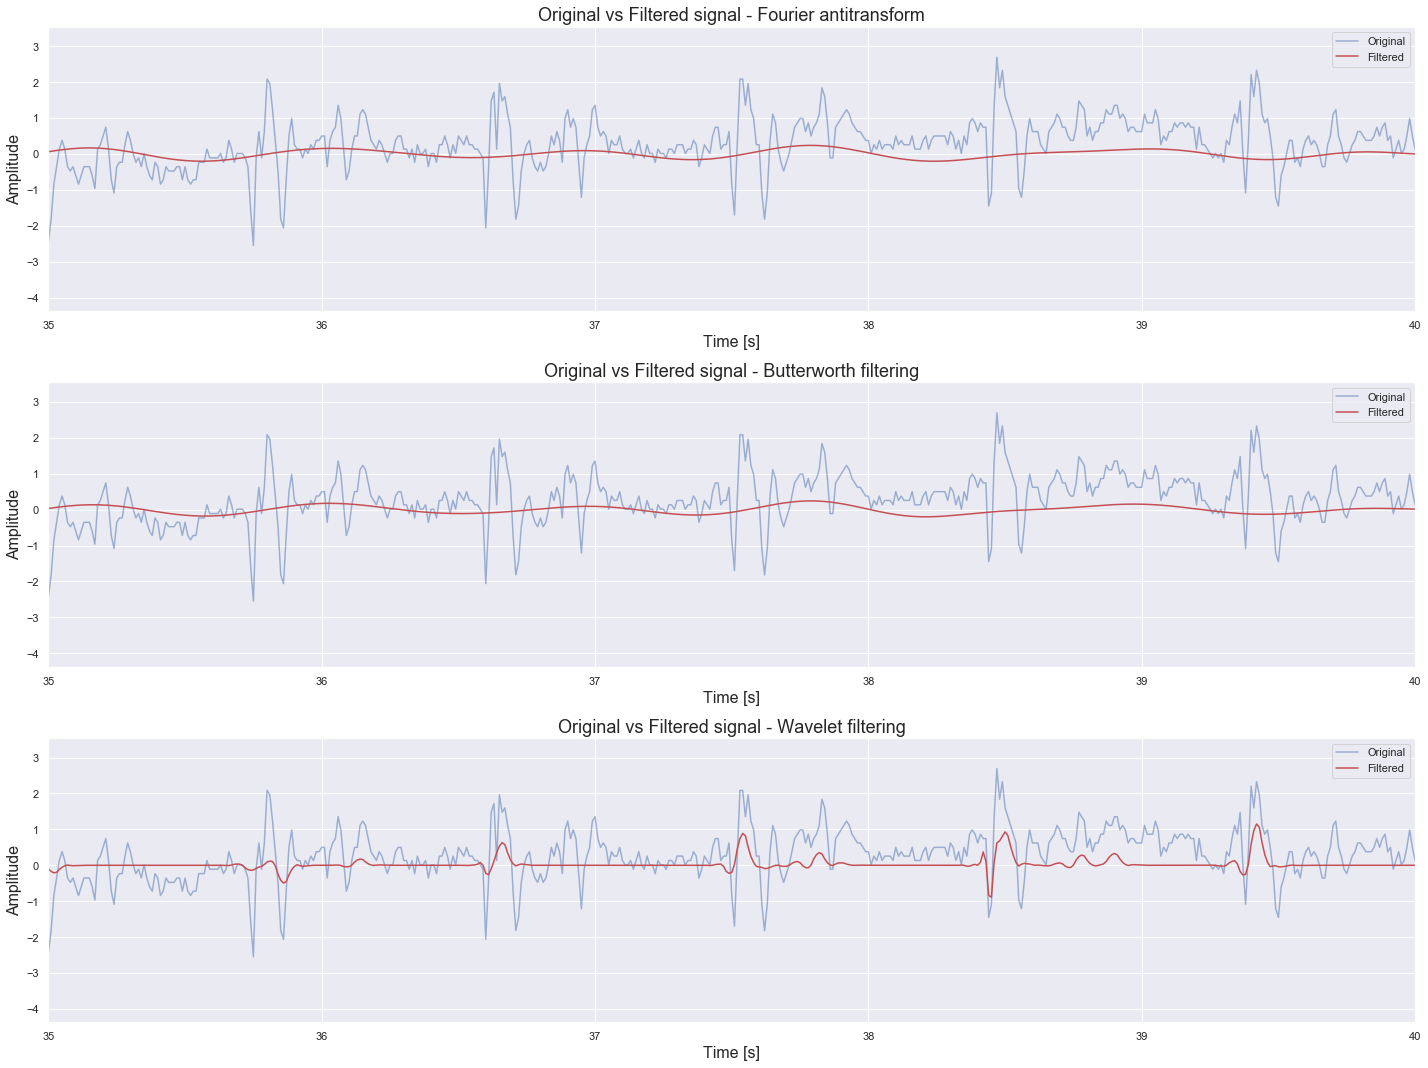

In [15]:
# Plot
figure, axis = plt.subplots(3, 1, figsize = (20, 15))

axis[0].plot(time, selected, 'b', alpha = 0.5, label = 'Original')
axis[0].plot(time, sig_filt_fft, 'r', label = 'Filtered')
axis[0].set_xlim([35,40])
axis[0].set_title("Original vs Filtered signal - Fourier antitransform", fontsize = 18)
axis[0].set_xlabel('Time [s]', fontsize = 16)
axis[0].set_ylabel('Amplitude', fontsize = 16)
axis[0].legend()
axis[1].plot(time, selected, 'b', alpha = 0.5, label = 'Original')
axis[1].plot(time, sig_filt_butter, 'r', label = 'Filtered')
axis[1].set_xlim([35,40])
axis[1].set_title("Original vs Filtered signal - Butterworth filtering", fontsize = 18)
axis[1].set_xlabel('Time [s]', fontsize = 16)
axis[1].set_ylabel('Amplitude', fontsize = 16)
axis[1].legend()
axis[2].plot(time, selected, 'b', alpha = 0.5, label = 'Original')
axis[2].plot(time, wavelet_filt[len(wavelet_filt)-len(time):], 'r', label = 'Filtered')
axis[2].set_xlim([35,40])
axis[2].set_title("Original vs Filtered signal - Wavelet filtering", fontsize = 18)
axis[2].set_xlabel('Time [s]', fontsize = 16)
axis[2].set_ylabel('Amplitude', fontsize = 16)
axis[2].legend()
figure.tight_layout()
#plt.savefig("Images/BCG/Original_filt.png")

plt.show()

**Peaks detection**

In [16]:
peaks_fft,_ = find_peaks(sig_filt_fft, height=0.1, threshold=None, distance=fs/hf, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
peaks_butt,_ = find_peaks(sig_filt_butter, height=0.1, threshold=None, distance=fs/hf, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
#peaks_wave,_ = find_peaks(sig_filt_wavelet, height=0.2, threshold=None, distance=fs/hf, prominence=0.4, width=None, wlen=None, rel_height=0.5, plateau_size=None)
peaks_wavelet,_ = find_peaks(np.abs(wavelet_filt), height=0.4, threshold=None, distance=fs/hf, prominence=None, width=None, wlen=None, rel_height=None, plateau_size=None)

Text(0, 0.5, 'Amplitude')

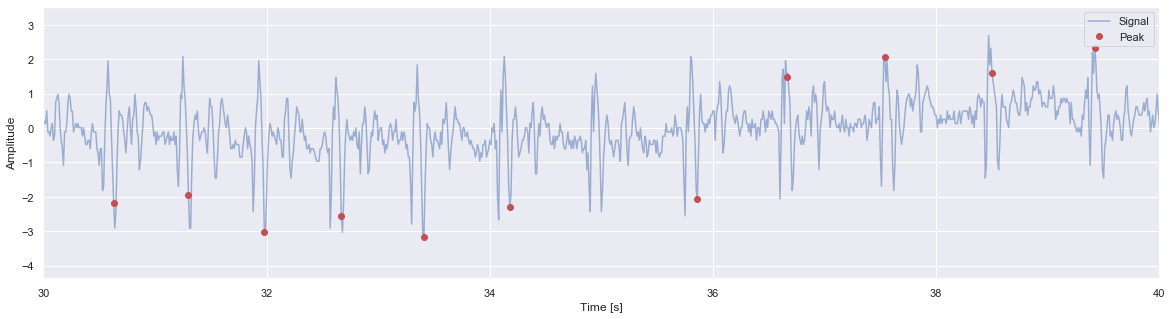

In [17]:
fig = plt.figure(figsize=(20, 5))
plt.plot(time, selected, 'b',alpha=0.5, label = 'Signal')
plt.plot(time[peaks_wavelet], selected.iloc[peaks_wavelet], 'o', color = 'r', label = 'Peak')
plt.legend(loc="best")
ax = fig.get_axes()
ax[0].set_xlim([30,40])
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('Amplitude')
#plt.savefig("Images/BCG/Peak.png")

**Metrics:**

In [18]:
print("mean BPM with FFT filt= ",len(peaks_fft)*60/(len(sig_filt_fft)/fs))
print("mean BPM with butterworth filt= ",len(peaks_butt)*60/(len(sig_filt_butter)/fs))
print("mean BPM with wavelet filt= ",len(peaks_wavelet)*60/(len(wavelet_filt)/fs))

mean BPM with FFT filt=  67.0
mean BPM with butterworth filt=  68.0
mean BPM with wavelet filt=  74.0


**Curve fit**

Gamma fitting parameters:
Mean BPM =  76.06895908464722
HRV =  11.630011217940746


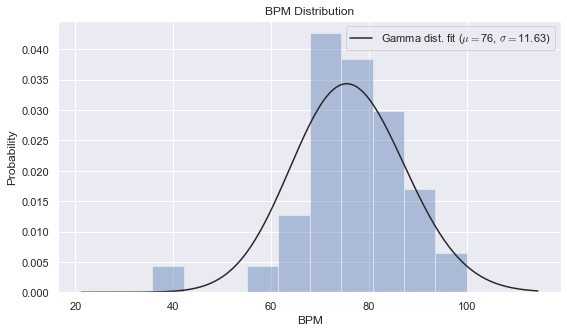

In [19]:
plt.rcParams['figure.figsize']=(9 ,5)
beat_indexes = peaks_wavelet
bpms = 60/(np.diff(beat_indexes)/fs)
ax = sns.distplot(bpms,kde=False, bins = 10,fit=stats.gamma);
ax.set_title('BPM Distribution')
ax.set(xlabel='BPM', ylabel='Probability')
param = stats.gamma.fit(bpms)
mu = stats.gamma.mean(param[0],param[1],param[2])
sigma = stats.gamma.std(param[0],param[1],param[2])
plt.legend(["Gamma dist. fit ($\mu=${0:.2g}, $\sigma=${1:.2f})".format(mu, sigma)])
print("Gamma fitting parameters:")
print("Mean BPM = ", mu)
print("HRV = ",sigma)
#plt.savefig("Images/BCG/fitting.png")